Time to generate Js: 0.017953157424926758 sec
time for spiking net sim =  22.531480073928833 s
time for rate net sim =  0.038532257080078125 s


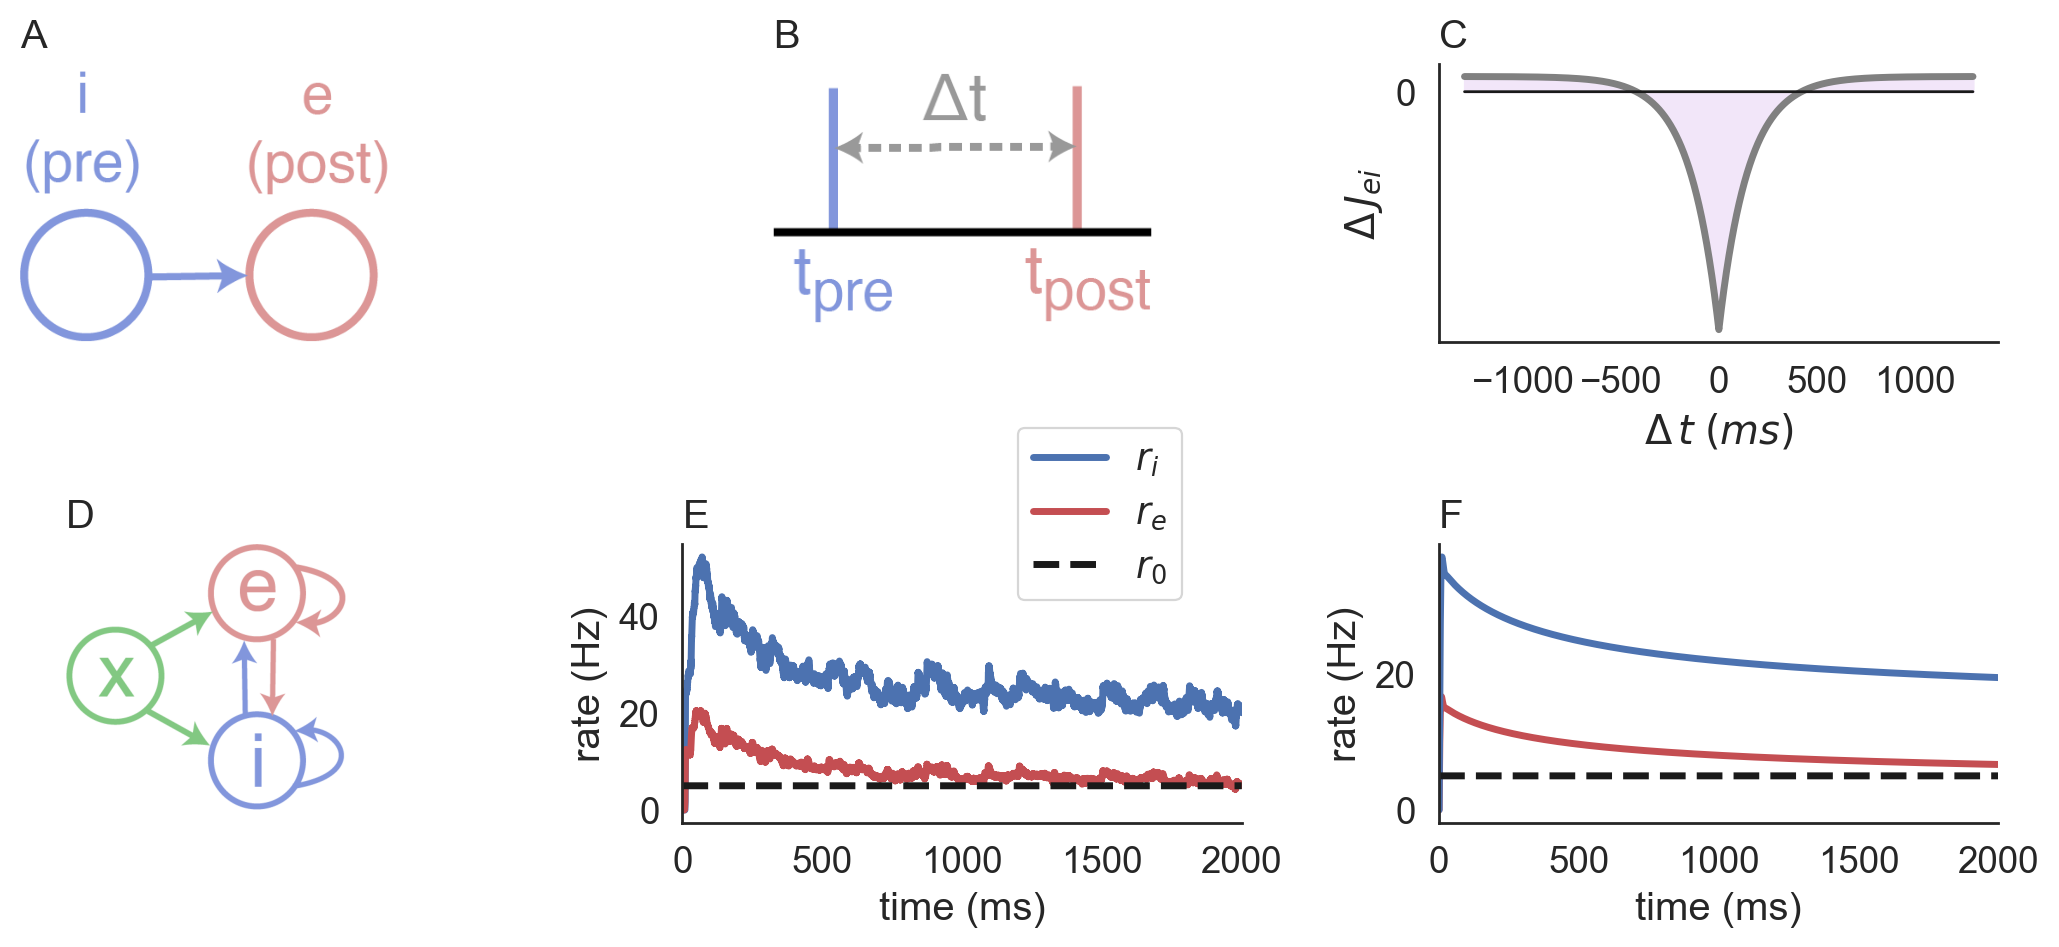

In [2]:
###############################################
## Import packages and specify some settings ##
###############################################
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# This makes plots show up and look nice
%matplotlib inline
sns.set(context='paper',style='white',font_scale=1.5,rc={"lines.linewidth":2.5})
sns.set_palette('muted')
%config InlineBackend.figure_format = 'retina'

###############################################
###############################################

# For computing runtimes
from time import time as tm

# Seed random number generator so that
# we get the same results every time
# we run this code
np.random.seed(5)


plt.subplots(2,3,figsize=(11,5))


##################################
# First let's make a plot of Delta J versus Delta t.
# Note: We will use different params for the network.
##################################

epsilon = 1;
tauy = 150;
r0 = 30/1000;
dts=np.arange(-1300,1300,1)
dJs=-(epsilon/tauy)*(np.exp(-np.abs(dts)/tauy) - 2*r0)

plt.subplot(2,3,1)
# Get image for plot
try: 
    im = plt.imread('../ImageFiles/EIPairForPlast1.png')
except:
    try:
        url = "https://raw.githubusercontent.com/RobertRosenbaum/ModelingNeuralCircuits/master/ImageFiles/EIPairForPlast1.png"
        file = np.DataSource().open(url)
        im = plt.imread(file.name)
    except:
        im = 1.0+np.zeros([100,100,3],dtype=np.uint8)
plt.imshow(im,interpolation='hanning')
plt.axis('off')
plt.title('A',loc='left')

plt.subplot(2,3,2)
# Get image for plot
try: 
    im = plt.imread('../ImageFiles/EIPairForPlast2.png')
except:
    try:
        url = "https://raw.githubusercontent.com/RobertRosenbaum/ModelingNeuralCircuits/master/ImageFiles/EIPairForPlast2.png"
        file = np.DataSource().open(url)
        im = plt.imread(file.name)
    except:
        im = 1.0+np.zeros([100,100,3],dtype=np.uint8)
plt.imshow(im,interpolation='hanning')
plt.axis('off')
plt.title('B',loc='left')

plt.subplot(2,3,3)
plt.plot(dts,dJs,color=[.5,.5,.5])
plt.plot(dts,0*dJs,'k',linewidth=1)
plt.fill_between(dts,dJs,where=dJs<100000,color=[.95,.9,.975])
#plt.fill_between(dts,dJs,where=dJs>0,color=[.85,.975,.85])
plt.ylabel(r"$\Delta\, J_{ei}$")
plt.xlabel(r"$\Delta\, t \;(ms)$")
plt.yticks([0])
plt.title('C',loc='left')
plt.xticks([-1000,-500,0,500,1000])
sns.despine()



##################################
### Now let's do a spiking network simulation
##################################

# Discretized time
T=2000
dt=.1
time=np.arange(0,T,dt)
Nt=len(time)

# Number of external, exc and inh neurons
Nx=800
Ne=800
Ni=200 

# # Connection strengths
jex=30.0
jix=20.0
jee=12.0
jei=-45.0
jie=35.0
jii=-70.0

# Connection probabilities
pex=.2
pix=.2
pee=.2 
pei=.2 
pie=.2 
pii=.2

# External neuron firing rates
rx=10/1000

# EIF neuron parameters
taum=10 
EL=-72 
Vre=-72 
VT=-55 
D=2 
Vth=0


# Synaptic time constants
taux=8
taue=6
taui=4

# Plasticity parameters
tauy=150
epsilon=50.0
r0=5/1000


# Generate external spike trains as Poisson processes
Sx=np.random.binomial(1,rx*dt,(Nx,len(time)))/dt

# Initialize membrane potentials randomly
Ve=np.random.rand(Ne)*(VT-EL)+EL
Vi=np.random.rand(Ni)*(VT-EL)+EL


# Initialize all else as zeros
Iex=np.zeros(Ne)
Iee=np.zeros(Ne)
Iei=np.zeros(Ne)
Iix=np.zeros(Ni)
Iie=np.zeros(Ni)
Iii=np.zeros(Ni)
ye=np.zeros(Ne)
yi=np.zeros(Ni)
Se=np.zeros((Ne,len(time)))
Si=np.zeros((Ni,len(time)))


# Connection matrices
t0=tm()
Jex=jex*np.random.binomial(1,pex,(Ne,Nx))
Jee=jee*np.random.binomial(1,pee,(Ne,Ne))
Jei=jei*np.random.binomial(1,pei,(Ne,Ni))
Jix=jix*np.random.binomial(1,pix,(Ni,Nx))
Jie=jie*np.random.binomial(1,pie,(Ni,Ne))
Jii=jii*np.random.binomial(1,pii,(Ni,Ni))
print('Time to generate Js:',tm()-t0,'sec')



Omegaei=np.zeros((Ne,Ni))
Omegaei[Jei<0]=1

t0=tm()
eNumSpikes=0
iNumSpikes=0
iX=0
for i in range(len(time)-1):

    
    # Euler step for membrane potentials
    Ve=Ve+dt*(-(Ve-EL)+D*np.exp((Ve-VT)/D)+Iex+Iee+Iei)/taum 
    Vi=Vi+dt*(-(Vi-EL)+D*np.exp((Vi-VT)/D)+Iix+Iie+Iii)/taum 

    # Euler step for synaptic currents
    Iex=Iex+dt*(-Iex+Jex@Sx[:,i])/taux      
    Iee=Iee+dt*(-Iee+Jee@Se[:,i])/taue
    Iei=Iei+dt*(-Iei+Jei@Si[:,i])/taui    
    Iix=Iix+dt*(-Iix+Jix@Sx[:,i])/taux    
    Iie=Iie+dt*(-Iie+Jie@Se[:,i])/taue
    Iii=Iii+dt*(-Iii+Jii@Si[:,i])/taui
    ye=ye+dt*(-ye+Se[:,i])/tauy
    yi=yi+dt*(-yi+Si[:,i])/tauy
    Jei=Jei-dt*epsilon*(np.outer(ye-2*r0,Si[:,i])+np.outer(Se[:,i],yi))*Omegaei
    Jei=np.minimum(Jei,0)
     
    # Find which excitatory neurons spiked.
    Inds=np.nonzero(Ve>=Vth)[0]
    # Reset membrane potentials
    Ve[Inds]=Vre
    # Store spikes as delta functions
    Se[Inds,i+1]=1/dt
    
    # Now do the same for inhibitory neurons
    Inds=np.nonzero(Vi>=Vth)[0] 
    Vi[Inds]=Vre
    Si[Inds,i+1]=1/dt    
      
    
print('time for spiking net sim = ',tm()-t0,'s')


# Compute population-averged rates across time
re=np.mean(Se,axis=0)
ri=np.mean(Si,axis=0)

# Smooth the population-averaged rates
sigma=25
s=np.arange(-3*sigma,3*sigma,dt)
k=np.exp(-(s**2)/(2*sigma**2)) # Gaussian kernel
k[s<0]=0 # Make it causal
k=k/(sum(k)*dt)
re=np.convolve(k,re,'same')*dt
ri=np.convolve(k,ri,'same')*dt


plt.subplot(2,3,4)
# Get image for plot
try: 
    im = plt.imread('../ImageFiles/EIRecurrentNet.png')
except:
    try:
        url = "https://raw.githubusercontent.com/RobertRosenbaum/ModelingNeuralCircuits/master/ImageFiles/EIRecurrentNet.png"
        file = np.DataSource().open(url)
        im = plt.imread(file.name)
    except:
        im = 1.0+np.zeros([100,100,3],dtype=np.uint8)
plt.imshow(im,interpolation='hanning')
plt.axis('off')
plt.title('D',loc='left')



plt.subplot(2,3,5)
plt.plot(time,1000*ri,'b',label=r'$r_i$')
plt.plot(time,1000*re,'r',label=r'$r_e$')
plt.plot(time,1000*r0+np.zeros_like(time),'k--',label=r'$r_0$')
plt.xlim([0,T])
plt.xlabel('time (ms)')
plt.ylabel('rate (Hz)')
plt.title('E',loc='left')
plt.legend(loc=(.6,.8))
sns.despine()



##################################
# Now let's do a mean-field rate model
##################################

reMF=np.zeros(len(time))
riMF=np.zeros(len(time))

# Mean-field connectivity
wex=jex*pex*Nx 
wix=jix*pix*Nx 
wee=jee*pee*Ne 
wei=jei*pei*Ni 
wie=jie*pie*Ne
wii=jii*pii*Ni 
wex=jex*pex*Nx 
wix=jix*pix*Nx 

# Mean-field external input
Xe=wex*rx
Xi=wix*rx

# Time constants for rate equation
taue=30
taui=15

epsilonr=2*epsilon*Ni*pei

# g and theta from the fit in EIFficurve.ipynb
g = 0.00358
theta = 9.64

# Define f-I curve
def f(I):
    return g*(I-theta)*(I>theta)

t0=tm()
for i in range(len(time)-1):
    reMF[i+1]=reMF[i]+(dt/taue)*(-reMF[i]+f(wee*reMF[i]+wei*riMF[i]+Xe))
    riMF[i+1]=riMF[i]+(dt/taui)*(-riMF[i]+f(wie*reMF[i]+wii*riMF[i]+Xi))
    wei=wei-dt*epsilonr*(reMF[i]-r0)*riMF[i]
print('time for rate net sim = ',tm()-t0,'s')    


plt.subplot(2,3,6)
plt.plot(time,1000*reMF,'r',label=r'$r_e$')
plt.plot(time,1000*riMF,'b',label=r'$r_i$')
plt.plot(time,1000*r0+np.zeros_like(time),'k--',label=r'$r_0$')
plt.xlim([0,T])
plt.xlabel('time (ms)')
plt.ylabel('rate (Hz)')
plt.title('F',loc='left')
#plt.legend(loc=(.6,.8))
sns.despine()


plt.tight_layout()


